# Определение возраста покупателей

***Цель исследования:*** Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нам нужно построить и обучить свёрточную нейронную сеть, которая по фотографии определит приблизительный возраст человека.

Значение метрики качества MAE на тестовой выборке должно быть не больше 8.

***Ход исследования:*** Планируется 3 этапа:
1. Исследовательский анализ данных;
2. Обучение модели;
3. Анализ обученной модели.

***Описание данных:*** Данные с отметкой возраста лежат в файле `/datasets/faces/labels.csv`. Изображения людей в формате .jpg находятся в папке `/datasets/faces/final_files/`.

In [1]:
# Импортируем необходимые библиотеки и методы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense
from keras import metrics

## Исследовательский анализ данных

In [2]:
# Обозначим папку с необходимым датасетом.
PATH = '/datasets/faces/'

# Загрузим файл с отметкой возраста в датафрейм.
labels = pd.read_csv(PATH + 'labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
# Оценим размер выборки.
labels.info()
labels.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [4]:
# Проверим датафрейм на дубликаты.
labels['file_name'].duplicated().sum()

0

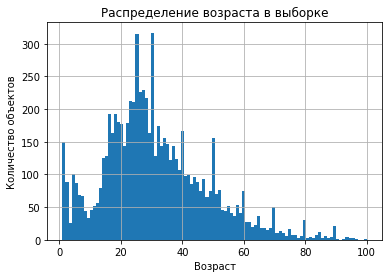

In [5]:
# Построим гистограмму распределения возраста в выборке.
labels.hist(bins=100)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество объектов')
plt.show()


Файл   : 000000.jpg
Возраст: 4


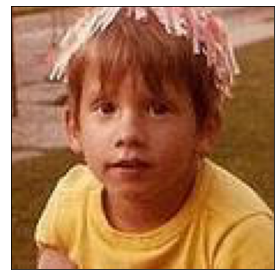


Файл   : 000001.jpg
Возраст: 18


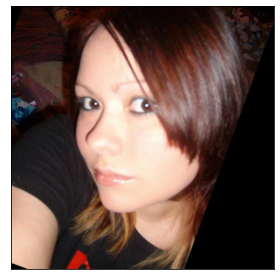


Файл   : 000002.jpg
Возраст: 80


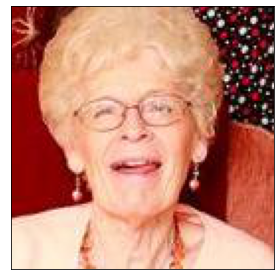


Файл   : 000003.jpg
Возраст: 50


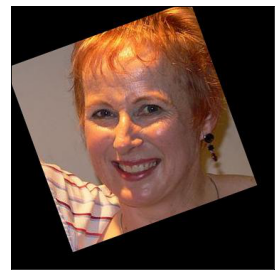


Файл   : 000004.jpg
Возраст: 17


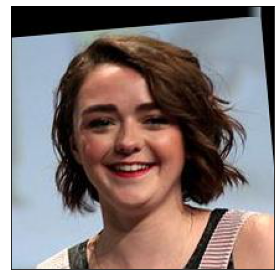


Файл   : 000005.jpg
Возраст: 27


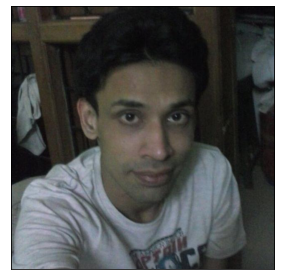


Файл   : 000006.jpg
Возраст: 24


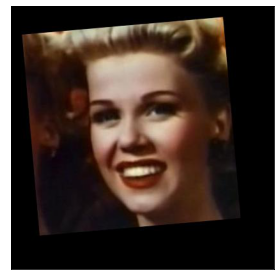


Файл   : 000007.jpg
Возраст: 43


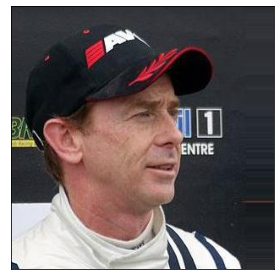


Файл   : 000008.jpg
Возраст: 26


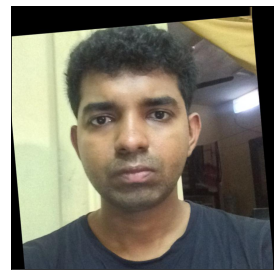


Файл   : 000009.jpg
Возраст: 39


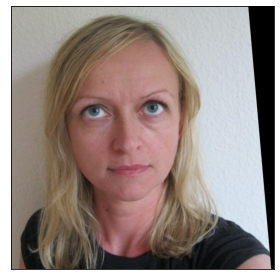


Файл   : 000010.jpg
Возраст: 17


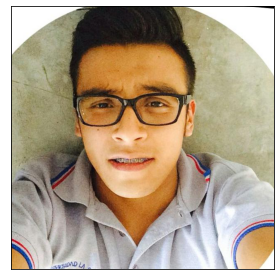


Файл   : 000011.jpg
Возраст: 51


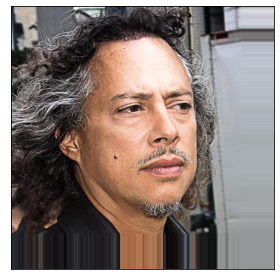

In [6]:
# Выведем первые 12 фотографий.
for i in range(12):
    
    print()
    print('Файл   :', labels.loc[i, 'file_name'])
    print('Возраст:', labels.loc[i, 'real_age'])
    
    if i < 10:
        image = Image.open(PATH + 'final_files/00000' + str(i) + '.jpg')
    else:
        image = Image.open(PATH + 'final_files/0000' + str(i) + '.jpg')
    plt.imshow(np.array(image))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

**Промежуточный вывод:** Видим фотографии людей и файл с их возрастом. Размер выборки - 7591 промаркированных фото, без пропусков и дубликатов. Визуально первые фотографии примерно соответствуют указанному возрасту. На изображениях заметны артефакты и подгоны под размер, что значит, дополнительно обрабатывать их не потребуется.

Из гистограммы видим, что распределение данных о возрасте похоже на нормальное, с выбросом около нуля, пик смещён влево - к медиане в 29 лет. Заметны выбросы каждые 10 лет, что может говорить об округлении возраста. Это может помешать модели точно его
предсказывать.

Судя по процентилям распределения данных, видим дизбаланс классов, да и данных для высокой точности предсказания может оказаться недостаточно. Возможно, следует провести аугментацию фотографий.

## Обучение модели

Данные для модели уже подготовлены, так что можно сразу приступать к обучению. Код в этом разделе запускался на облачной GPU-платформе, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке. Под кодом находится вывод тренажёра за исключением информации о загрузке и инициализации.

```python
def load_train(path):
        train_datagen = ImageDataGenerator(validation_split=0.25,
                                           rescale=1/255,
                                           horizontal_flip = True)

        train_datagen_flow = train_datagen.flow_from_dataframe(
                dataframe=pd.read_csv(path + 'labels.csv'),
                directory=(path + '/final_files'),
                x_col='file_name',
                y_col='real_age',
                target_size=(224, 224),
                batch_size=32,
                class_mode='raw',
                subset='training',
                seed=12345)

        return train_datagen_flow

def load_test(path):
        validation_datagen = ImageDataGenerator(validation_split=0.25,
                                                rescale=1/255)

        val_datagen_flow = validation_datagen.flow_from_dataframe(
                dataframe=pd.read_csv(path + 'labels.csv'),
                directory=(path + '/final_files'),
                x_col='file_name',
                y_col='real_age',
                target_size=(224, 224),
                batch_size=32,
                class_mode='raw',
                subset='validation',
                seed=12345)

        return val_datagen_flow

def create_model(input_shape):
        backbone = ResNet50(input_shape=(150, 150, 3),
                            weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                            include_top=False)
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1, activation='relu'))

        optimizer = Adam(lr=0.0001)
        model.compile(optimizer=optimizer,
                      loss='mse',
                      metrics=['mae'])

        return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):

        if steps_per_epoch is None:
                steps_per_epoch = len(train_data)
        if validation_steps is None:
                validation_steps = len(test_data)

        model.fit(train_data,
                  validation_data=test_data,
                  batch_size=batch_size, epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps,
                  verbose=2, shuffle=True)

        return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/15
2025-01-20 12:36:32.767351: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-01-20 12:36:34.175563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 82s - loss: 221.4982 - mae: 10.7141 - val_loss: 851.8911 - val_mae: 24.3002
Epoch 2/15
178/178 - 57s - loss: 72.5624 - mae: 6.4288 - val_loss: 747.6626 - val_mae: 22.2864
Epoch 3/15
178/178 - 57s - loss: 49.3015 - mae: 5.3293 - val_loss: 408.6463 - val_mae: 15.5843
Epoch 4/15
178/178 - 57s - loss: 34.7551 - mae: 4.5190 - val_loss: 104.9337 - val_mae: 7.5679
Epoch 5/15
178/178 - 57s - loss: 27.1484 - mae: 3.9689 - val_loss: 85.1414 - val_mae: 7.0224
Epoch 6/15
178/178 - 47s - loss: 22.2603 - mae: 3.6487 - val_loss: 74.8219 - val_mae: 6.7564
Epoch 7/15
178/178 - 47s - loss: 18.1419 - mae: 3.2785 - val_loss: 79.6733 - val_mae: 6.5221
Epoch 8/15
178/178 - 47s - loss: 15.2587 - mae: 2.9868 - val_loss: 67.1052 - val_mae: 6.1714
Epoch 9/15
178/178 - 48s - loss: 11.9244 - mae: 2.6294 - val_loss: 68.8225 - val_mae: 6.2558
Epoch 10/15
178/178 - 47s - loss: 10.7815 - mae: 2.5102 - val_loss: 65.2933 - val_mae: 6.1782
Epoch 11/15
178/178 - 48s - loss: 9.9704 - mae: 2.3895 - val_loss: 67.7314 - val_mae: 6.0258
Epoch 12/15
178/178 - 47s - loss: 8.5926 - mae: 2.2417 - val_loss: 60.0590 - val_mae: 5.7731
Epoch 13/15
178/178 - 47s - loss: 8.3734 - mae: 2.1684 - val_loss: 77.2773 - val_mae: 6.4617
Epoch 14/15
178/178 - 48s - loss: 8.7857 - mae: 2.2450 - val_loss: 64.1809 - val_mae: 5.9890
Epoch 15/15
178/178 - 47s - loss: 7.5871 - mae: 2.0902 - val_loss: 63.0832 - val_mae: 5.8114

60/60 - 12s - loss: 63.0832 - mae: 5.8114
```

**Промежуточный вывод:** MAE для указанной модели на валидационной выборке = 5.8, что удовлетворяет заданному условию.

## Анализ обученной модели

**Цель исследования:** Построили и обучили свёрточную нейронную сеть, которая по фотографии определяет приблизительный возраст человека.

**Подготовка данных:** Проверили данные на пропуски, дубликаты и визуальное соответствие задаче. Датасет был заранее обработан и готов к работе.

**Обучение модели:** Код в этом разделе запускался в отдельном GPU-тренажёре. Для тренажёра были написаны функции, код прошёл предварительную проверку. Проводилась аугментация всех тренировочных данных. В разделе приведён вывод тренажёра за исключением информации о загрузке и инициализации.

MAE для указанной модели на валидационной выборке = 5.8, что удовлетворяет заданному заказчиком условию.

**Рекомендации:** Ошибка в 5.8 лет может быть критичной для контроля добросовестности кассиров при продаже алкоголя. Уменьшить ошибку можно, изменив входные данные различными способами:
- Более точно промаркировать возраст, снизив количество округлений.
- Устранить дизбаланс классов дополнительной аугментацией или расширением отдельных возрастных групп.

Однако, для другой цели - анализа покупок и предложений товаров по возрастным группам - эту модель можно использовать как есть.